<a href="https://colab.research.google.com/github/MahmutRuzi/CA_images2classification/blob/main/CA_image2Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created to demonstrate a simple example of classification task using basic scikit-learn modules. The task is to learn a limited number of contact angle (CA) pictures of a small (a few mm in diameter) water droplet on a flat surface.

The CA is commonly used to characterize the wetting properties of a solid surface and is generally measured by taking pictures of a water droplet on the surface. The CA takes the values between zero and 180 degress. When water wetts a solid surface, the solid is called hydrophilic and the CA is very low. When water does not wett well, then the surface is called hydrophobic and the CA is generally above 90 degrees. If water does not wett a surface at all, a water droplet on such surfaces take almost spherical shape and the CA will be larger than 150 degrees. Such extremelly water repellent surfaces a called superhydrophobic. If the topics sounds interesting and you want learn more, please read my blog post on the topic. https://mahmutruzi.github.io/posts/2021/02/2021-02-07-What-is-superhydrophobicity/



The data we use is images of water CA and the corresponding labels: 2 for superhydrophobic, 1 for hydrophobic, and 0 for hydrophilic. The data is a numpy array saved in compressed format (npz) and named "labeled_CA_data.npz". The data comprises of 33 images for class 2, 38 images for class 1, and 28 images of class 0. To use the data, download the raw data from the github repository, then upload to colab session storage. For uploading, click the files symbol (below the key symbol) on the left pane, then click then up arrow symbol. Follow the pop up window to upload the "labeled_CA_data.npz" file.

After that, we need to import modules that will be used later. Besides the commonly used standard libraries like numpy for numerical computation and matplotlib for visualization, we also import some scikit-learn modules for preprocessing, classification, and visualization.

For classification, we use support vector machines (svm) and decision tree, both of which will be imported from sklearn (short for scikit-learn). Additionally, we also explore gradient boosting using another python packacge called xgboost.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, loguniform
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, LearningCurveDisplay
from sklearn.metrics import  accuracy_score, classification_report, ConfusionMatrixDisplay


It should be noted that the packages should be installed before being able to import that. However, it seems all these packages are automatically included in colab. Otherwise, when the run the above, it will give an error. Just to be sure, we can check the libraries and which version we are using.

In [ ]:
print(np.__version__)
print(xgb.__version__)

1.23.5
2.0.2


Now we load the data using numpy and extract the images and labels.

In [ ]:
# load the data
raw_data = np.load('labeled_CA_data.npz')
# retrieve attributes
ca_imgs = raw_data["images"]
lab_class = raw_data["labels"]

Now lets look at the data,and plot some of the images. Here, we use a small function to plot first 10 images.

The number of smaples is: 99
Each image size is: (32, 32)


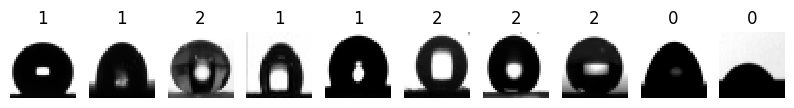

In [ ]:
# explore the data
n_samples = len(ca_imgs)
img_size = ca_imgs.shape
print(f"The number of smaples is: {n_samples}")
print(f"Each image size is: {img_size[1:]}")

# function to plot
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 4))
for ax, image, label in zip(axes, ca_imgs, lab_class):
    ax.set_axis_off()
    ax.imshow(image, cmap='gray', interpolation="None")
    ax.set_title("%i" % label)

The data is (99, 32,32) in size. We need to flatten the data so that each row corresponds to one image. Furthermore, the image is grayscale 256 bit,we need to scale it as well. Then, we split the data into training set and test sets. We use the train_test_split functionality of sklearn we imported earlier.

In [ ]:
# flatten images, and scale
data = ca_imgs.reshape((n_samples, -1))/255

# split the data into 80% train and 20% test subset
X_train, X_test, y_train, y_test = train_test_split(data, lab_class,
                                                    test_size=0.2, shuffle=True,
                                                    random_state=42,
                                                    stratify=lab_class)

In the code above, we split the data into 20% test set while while the rest is reserved for training. shuffle=True ensures the data is randomly shuffled before splitting and stratify=lab_class ensures that both the training set and test set has about the same percentage of samples of each class.

Now the data is ready for classification. In the first example, we use svm classifier to learn the training data and evaluate its accuracy using the test sets. For classifcation using svm, we need to provide certain paramters. Here, we choose to optimize these paramters as well. For that purpose, we use the RandomizedSearchCV function.

In [ ]:
# create SVM classifier, scan for best parameters

param_dist = {
    'kernel': ['linear','poly','rbf'],
    "C": loguniform(0.1, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}

estimator_svc = svm.SVC(class_weight='balanced')
n_param_samples = 100
clf1 = RandomizedSearchCV(estimator_svc, param_dist, n_iter=n_param_samples,
                          scoring='accuracy', cv=5,
                          random_state=42)

In the above lines, we scan for kernel functions, the regularization paramter C, and the kernel function coefficeint gamma. Then, we initiate the svm classifier with class_weight='balanced' to take the number of samples within each class into account. The next step is the RandomizedSearchCV parameters. Here, n_iter is the number parameter sets to scann, scoring is choose which scoring function to use,and cv means number of cross-validation.

The next step is training (fitting) the model on the training data sets.

In [ ]:
svc_estimator = clf1.fit(X_train, y_train)

print("Best estimator found by grid search:")
print(f"best parameters: {svc_estimator.best_params_}")
print(f"Mean cross-validated score: {svc_estimator.best_score_:.2f}")

Best estimator found by grid search:
best parameters: {'C': 7.343344964174937, 'gamma': 0.0009452571391072313, 'kernel': 'rbf'}
Mean cross-validated score: 0.70


Then we can use the best parametes to retrain the model, make prediction, and then can compare the predicted results to the test set data.

In [ ]:
# learn the images using the best parameters
# initiate the svm classifier
svc_best = svm.SVC(C=10, kernel="rbf", gamma=0.0007, class_weight='balanced',
              random_state=42)
# fit the classfier using the training datatset
svc_best.fit(X_train, y_train)
# predict
predicted = svc_best.predict(X_test)

svc_accuracy = accuracy_score(y_test, predicted)
print("Accuracy (train) for SVC: %0.1f%% " % (svc_accuracy * 100))

Accuracy (train) for SVC: 85.0% 


We proceed further to print out a classification report and visualize the confusion matrix.

Classification report for classifier SVC(C=10, class_weight='balanced', gamma=0.0007, random_state=42):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.62      0.77         8
           2       0.78      1.00      0.88         7

    accuracy                           0.85        20
   macro avg       0.87      0.88      0.85        20
weighted avg       0.88      0.85      0.84        20


Confusion matrix:
[[1.    0.    0.   ]
 [0.125 0.625 0.25 ]
 [0.    0.    1.   ]]


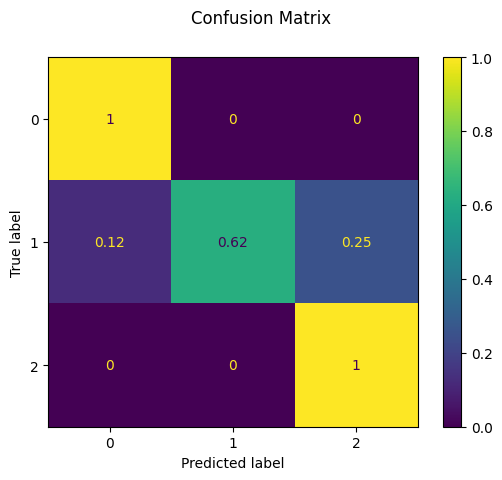

In [ ]:
print(
    f"Classification report for classifier {svc_best}:\n"
    f"{classification_report(y_test, predicted)}\n")

disp = ConfusionMatrixDisplay.from_predictions(y_test, predicted,normalize='true')
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Next, we follow similar routine to train the data employing decision tree. For that, we use RandomizedSearchCV function to optimize parameters.

In [ ]:
# DecisionTree classifier

n_param_samples2 = 100

# Define the parameter grid to search
param_dist = {
    "max_depth": [2, 3, 4, 5, 6, 7],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11),
    "criterion": ["gini", "entropy"]
}

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42,class_weight='balanced',
                             max_features='log2')

# Initialize the RandomizedSearchCV object
dt_tune = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_param_samples2, cv=5, verbose=False,
                                   random_state=42, scoring='accuracy')

Now, we need to train the data and find the best parameters that give us the best score (accuracy).

In [ ]:
# Fit the model on the training data
dt_tune.fit(X_train, y_train)

# Print the best parameters
print(f"Mean cross-validated score: {dt_tune.best_score_:.2f}")
print(dt_tune.best_params_)

Mean cross-validated score: 0.71
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 5}


Now, we can use the best paramters to initiate a deicision tree classifier, train on the data, make predictions, and calculate accuracy.

In [ ]:
# initiate a DT classifier using the best parameters
dt_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                      min_samples_leaf=3, min_samples_split=5,
                                      max_features='log2', random_state=42,
                                      class_weight='balanced')

# train the DT classifier
dt_estimator.fit(X_train, y_train)
# make prediction
y_pred_dt = dt_estimator.predict(X_test)
# prediction accuracy
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy (train) for DecisionTree: %0.1f%% " % (dt_accuracy * 100))

Accuracy (train) for DecisionTree: 55.0% 


The accuracy of the decision tree classifier is not great when compared to the svm classifier. One reason could be there is not enough data. To tests if this is the case, we plot learning curve on the training data set. A learning cruve gives as how the accuracy of traning change as we increase the data set size. The total number of samples is 99, we leave 20 for testing. Then, we have to give some instruction on how to change the size of the 77 training data set. In the following we set it as [5, 10,..79]. It begins with trainig with only five samples, then, 10, and up to 79 samples. During each training, the data itself is divided (?) into five (cross validation, cv=5) sets, then train seperately on 4 sets and the use the one set to tests; then repeat until all sets have been used as a test tests. This loop step is performed to obtain the best score (mean of all loops) for all training, which then be used to test accuracy on the test data set. Scikit-learn site has a very nice graphically explanation of what cross-validation does. Please visit the sie for clarity. https://scikit-learn.org/stable/modules/cross_validation.html

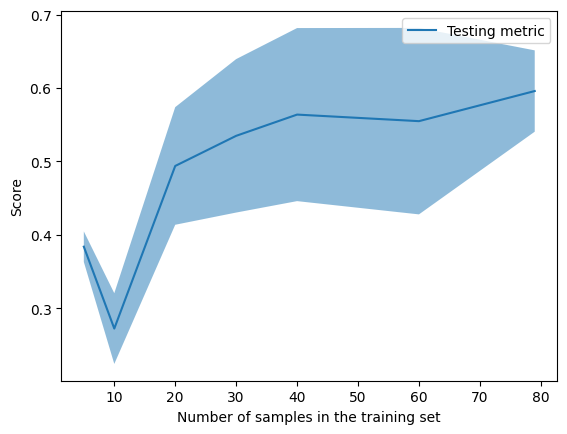

In [ ]:
# Make learning plot
train_sizes = [5, 10, 20, 30, 40, 60, 79]
# Plot learning curve
LearningCurveDisplay.from_estimator(DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=6,
                                                           min_samples_split=8,
                                                           min_samples_leaf=1,
                                                           max_features='log2',
                                                           class_weight='balanced',
                                                           random_state=42),
                                    data, lab_class, train_sizes=train_sizes,
                                    cv=5)



The last model we try is gradient boosting classifier using xgboost. We follow similae steps: initiate the classfier, scan for optimum paramters. One thing to notcie is that since we are trying to train on three classes, we use "multisoftmaxprob:logistic" as objective function, and explicitly declare num_class=3. Similarly, for the evaluation metric, we specify multi class log loss as "mlogloss".

In [ ]:
#xGB classify
# Setting the params

params = {"gamma": [0, 0.01, 0.1, 0.25, 1.0],"learning_rate": [0.01, 0.05, 0.1, 0.3],
          "max_depth": [3,4,5,6], "colsample_bytree": [0.3,0.5, 1],
          "min_child_weight": [0, 1, 3, 5, 10]}

xgb_clf_tun = xgb.XGBClassifier(booster='gbtree',tree_method='hist',
                                objective="multisoftprob:logistic", num_class=3,
                                seed=42, early_stopping_rounds=10,
                                eval_metric="mlogloss")
n_param_samples2 = 10
tuned_params = RandomizedSearchCV(xgb_clf_tun, params,
                            verbose=0, n_jobs=1, cv=5, n_iter=n_param_samples2,
                            random_state=42, scoring='accuracy')


Now, we scan the parameter space (100 combinations) while training on the data to obtain the best score.

In [ ]:
tuned_params.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)], verbose=False)
#%%
# Printing the best parameters

print(tuned_params.best_params_)

{'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.3}


Once we obtained the optimum parameters, we use them to fit the data, make prediction, calculate accuracy. Here, we use three different evaluation metreics fo data validation: multi class log loss, multi class classification error, and characteristic area under the curve.

In [ ]:
ev_metrics = ["mlogloss", "merror", "auc"] # Various metric parameters for later visualzation

clf_xgb_boosted = xgb.XGBClassifier(booster='gbtree',
                                    objective="multisoftprob:logistic",
                                    num_class=3, seed=42, gamma = 0.0,
                                    learning_rate=0.3, max_depth = 4,
                                    colsample_bytree =0.5, early_stopping_rounds=10,
                                    min_child_weight=0,
                                    eval_metric=ev_metrics)

clf_xgb_boosted.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Model prediction
y_pred_xgb_boosted = clf_xgb_boosted.predict(X_test)
# probablity of prediction
y_pred_xgb_prob = clf_xgb_boosted.predict_proba(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb_boosted )
print("Accuracy (train) for xgboost: %0.1f%% " % (xgb_accuracy * 100))

[0]	validation_0-mlogloss:0.86117	validation_0-merror:0.15000	validation_0-auc:0.91484
[1]	validation_0-mlogloss:0.74163	validation_0-merror:0.10000	validation_0-auc:0.93160
[2]	validation_0-mlogloss:0.68578	validation_0-merror:0.20000	validation_0-auc:0.91942
[3]	validation_0-mlogloss:0.60449	validation_0-merror:0.20000	validation_0-auc:0.95994
[4]	validation_0-mlogloss:0.56275	validation_0-merror:0.15000	validation_0-auc:0.95160
[5]	validation_0-mlogloss:0.54123	validation_0-merror:0.20000	validation_0-auc:0.95160
[6]	validation_0-mlogloss:0.52159	validation_0-merror:0.15000	validation_0-auc:0.94776
[7]	validation_0-mlogloss:0.48783	validation_0-merror:0.15000	validation_0-auc:0.95577
[8]	validation_0-mlogloss:0.47211	validation_0-merror:0.15000	validation_0-auc:0.95160
[9]	validation_0-mlogloss:0.46121	validation_0-merror:0.15000	validation_0-auc:0.94776
[10]	validation_0-mlogloss:0.44844	validation_0-merror:0.20000	validation_0-auc:0.95192
[11]	validation_0-mlogloss:0.45099	validat

At last, we display some figures such as confusion matrix and training epoch.

Confusion matrix:
[[1.    0.    0.   ]
 [0.125 0.5   0.375]
 [0.    0.    1.   ]]


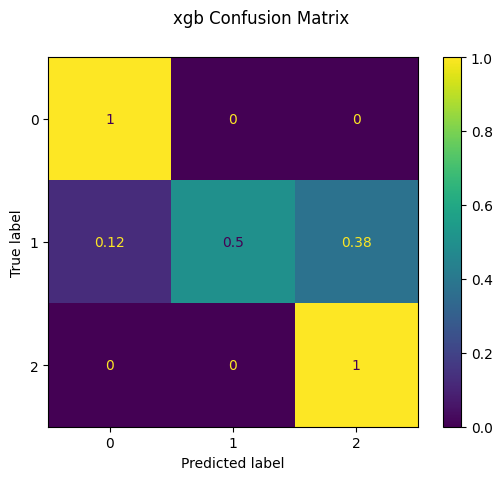

Text(0.5, 0, 'epoch')

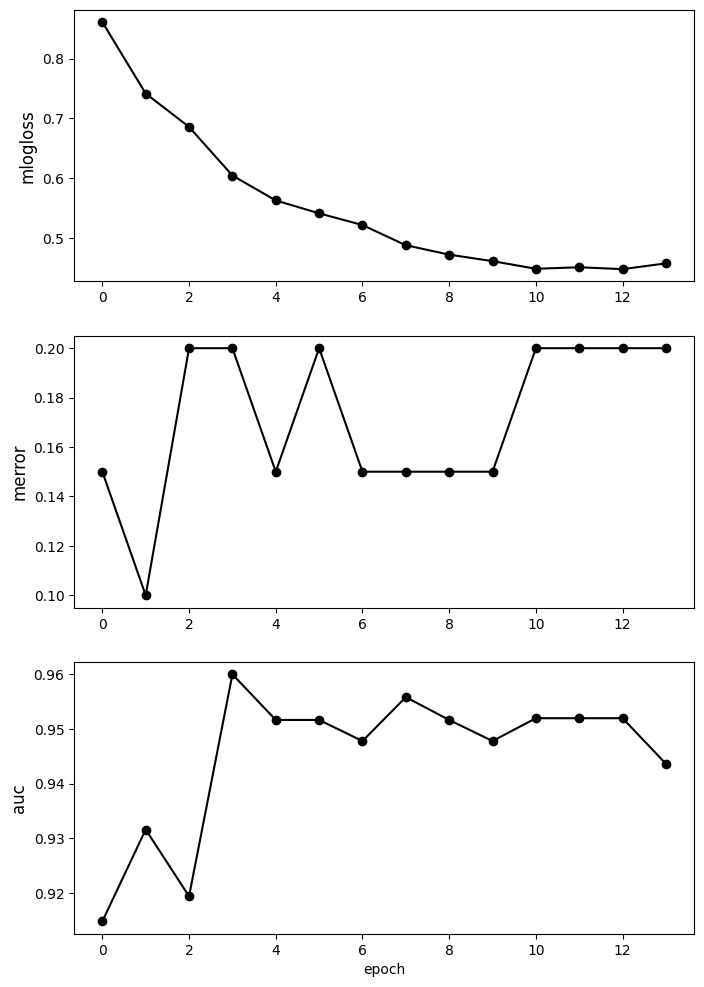

In [ ]:
# Plotting the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_boosted ,normalize='true')
disp.figure_.suptitle("xgb Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()
# retrieve training rate
results = clf_xgb_boosted.evals_result()

training_rate = results['validation_0']
epochs = len(training_rate[ev_metrics[0]])
x_axis = range(0, epochs)

num_sub_plots =len(ev_metrics)
#
fig, axs = plt.subplots(nrows=num_sub_plots, ncols=1, figsize=(8, 12))

for i in range(num_sub_plots):
    axs[i].plot(x_axis, training_rate[ev_metrics[i]],'k-o')
    axs[i].set_ylabel(ev_metrics[i], fontsize=12)

axs[i].set_xlabel('epoch')